# ItemKNN con Dataset Yoochoose

Este notebook implementa Item-based K-Nearest Neighbors (ItemKNN) entrenado en el dataset Yoochoose del RecSys Challenge 2015.

**Algoritmo**: Filtrado colaborativo basado en similitud entre ítems  
**Dataset**: Yoochoose (sesiones de e-commerce)  
**Métricas**: Recall@K, MRR@K, ILD@K, Popularity Bias@K

## 🔧 Instalación de Dependencias

In [1]:
# Instalación de dependencias necesarias
!pip install torch numpy pandas scikit-learn tqdm matplotlib seaborn psutil

# Imports principales
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import psutil
import datetime as dt
import os
import time
import json
import warnings
warnings.filterwarnings('ignore')

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("✅ Dependencias instaladas y configuradas correctamente")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

## 📊 Descarga y Preprocesamiento del Dataset Yoochoose

🔄 Descargando dataset Yoochoose...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  273M  100  273M    0     0  19.3M      0  0:00:14  0:00:14 --:--:-- 22.4M

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 287211932 bytes (274 MiB)

Extracting archive: data.7z
--
Path = data.7z
Type = 7z
Physical Size = 287211932
Headers Size = 255
Method = LZMA:24
Solid = +
Blocks = 2

  0%      0% - yoochoose-buys.dat                           1% - yoochoose-buys.dat                           2% - yoochoose-buys.dat                    

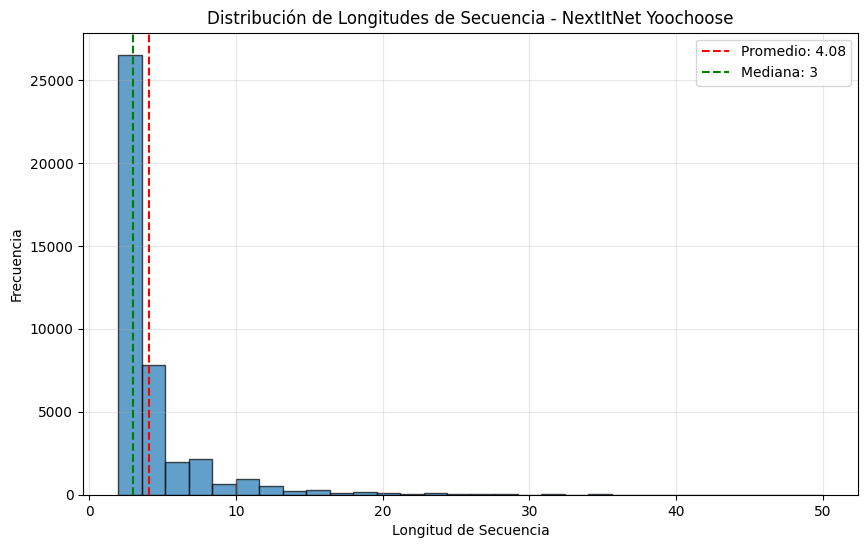

✅ Dataset Yoochoose procesado exitosamente:
   41,832 secuencias de entrenamiento
   15,044 secuencias de test
   Vocabulario size: 12339


In [2]:
# Descargar y extraer dataset Yoochoose
print("🔄 Descargando dataset Yoochoose...")

# Crear directorios necesarios
!mkdir -p data
!mkdir -p rsc15

# Descargar dataset
!curl https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z --output data.7z

# Extraer dataset
!7z e data.7z -o./rsc15
!rm data.7z

print("✅ Dataset Yoochoose descargado y extraído")

def load_and_preprocess_yoochoose(src_path='./rsc15/', use_fraction=64, max_seq_len=50):
    """
    Carga y preprocesa el dataset Yoochoose de forma optimizada
    """
    print("🔧 Procesando dataset Yoochoose...")

    # Cargar datos
    data = pd.read_csv(src_path + 'yoochoose-clicks.dat', sep=',', header=None,
                      usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
    data.columns = ['SessionId', 'TimeStr', 'ItemId']

    print(f"📊 Estadísticas iniciales:")
    print(f"   Total eventos: {len(data):,}")
    print(f"   Sesiones únicas: {data['SessionId'].nunique():,}")
    print(f"   Items únicos: {data['ItemId'].nunique():,}")

    # Agregar timestamp
    data['Time'] = data.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())
    del(data['TimeStr'])

    # Filtros estándar de Yoochoose
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>1].index)]

    item_supports = data.groupby('ItemId').size()
    data = data[np.in1d(data.ItemId, item_supports[item_supports>=5].index)]

    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>=2].index)]

    # División temporal: test = último día
    tmax = data.Time.max()
    session_max_times = data.groupby('SessionId').Time.max()

    session_train = session_max_times[session_max_times < tmax-86400].index
    train = data[np.in1d(data.SessionId, session_train)]

    session_test = session_max_times[session_max_times >= tmax-86400].index
    test = data[np.in1d(data.SessionId, session_test)]
    test = test[np.in1d(test.ItemId, train.ItemId)]
    tslength = test.groupby('SessionId').size()
    test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]

    # Usar fracción de datos para entrenamiento
    if use_fraction:
        print(f"🎯 Usando 1/{use_fraction} de los datos de entrenamiento...")
        length = len(train['ItemId'])
        first_session = train.iloc[length - length//use_fraction].SessionId
        train = train.loc[train['SessionId'] >= first_session]

    print(f"📊 Datos procesados:")
    print(f"   Train: {len(train):,} eventos, {train.SessionId.nunique():,} sesiones")
    print(f"   Test: {len(test):,} eventos, {test.SessionId.nunique():,} sesiones")

    # Convertir a secuencias
    def to_sequences(df):
        sessions = df.sort_values(['SessionId', 'Time']).groupby('SessionId')['ItemId'].apply(list)
        sequences = [seq for seq in sessions if len(seq) >= 2 and len(seq) <= max_seq_len]
        return sequences

    train_sequences = to_sequences(train)
    test_sequences = to_sequences(test)

    # Crear mapeo de items
    all_items = []
    for seq in train_sequences:
        all_items.extend(seq)

    unique_items = sorted(set(all_items))
    item_to_idx = {item: idx + 1 for idx, item in enumerate(unique_items)}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}

    # Convertir a índices
    train_sequences_idx = [[item_to_idx[item] for item in seq] for seq in train_sequences]

    # Filtrar test sequences para items conocidos
    test_sequences_filtered = []
    for seq in test_sequences:
        filtered_seq = [item_to_idx[item] for item in seq if item in item_to_idx]
        if len(filtered_seq) >= 2:
            test_sequences_filtered.append(filtered_seq)

    print(f"📊 Secuencias finales:")
    print(f"   Train: {len(train_sequences_idx):,} secuencias")
    print(f"   Test: {len(test_sequences_filtered):,} secuencias")
    print(f"   Vocabulario: {len(item_to_idx):,} items únicos")

    # Estadísticas de distribución
    seq_lengths = [len(seq) for seq in train_sequences_idx]
    plt.figure(figsize=(10, 6))
    plt.hist(seq_lengths, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(seq_lengths), color='red', linestyle='--',
                label=f'Promedio: {np.mean(seq_lengths):.2f}')
    plt.axvline(np.median(seq_lengths), color='green', linestyle='--',
                label=f'Mediana: {np.median(seq_lengths):.0f}')
    plt.xlabel('Longitud de Secuencia')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Longitudes de Secuencia - NextItNet Yoochoose')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return train_sequences_idx, test_sequences_filtered, item_to_idx, idx_to_item

# Procesar datos
train_sequences, test_sequences, item_to_idx, idx_to_item = load_and_preprocess_yoochoose(
    use_fraction=64  # Cambiar a None para dataset completo
)

print(f"✅ Dataset Yoochoose procesado exitosamente:")
print(f"   {len(train_sequences):,} secuencias de entrenamiento")
print(f"   {len(test_sequences):,} secuencias de test")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding


## 🔄 División del Dataset y Creación de DataLoaders

In [3]:
class SequentialDataset(Dataset):
    """Dataset optimizado para secuencias con padding dinámico"""

    def __init__(self, sequences, max_len=50):
        self.sequences = sequences
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Crear input y target sequences
        if len(seq) <= self.max_len:
            # Secuencia completa
            input_seq = seq[:-1]  # Todos menos el último
            target_seq = seq[1:]  # Todos menos el primero
        else:
            # Truncar secuencia
            input_seq = seq[:self.max_len]
            target_seq = seq[1:self.max_len+1]

        # Padding
        input_padded = [0] * (self.max_len - len(input_seq)) + input_seq
        target_padded = [0] * (self.max_len - len(target_seq)) + target_seq

        return torch.tensor(input_padded, dtype=torch.long), torch.tensor(target_padded, dtype=torch.long)

# Las secuencias ya están divididas por Yoochoose (temporal split)
print(f"📊 División del dataset (temporal):")
print(f"   Entrenamiento: {len(train_sequences):,} secuencias")
print(f"   Test: {len(test_sequences):,} secuencias")

# Calcular estadísticas para el max_len apropiado
all_lengths = [len(seq) for seq in train_sequences]
max_len_95 = int(np.percentile(all_lengths, 95))
max_len_99 = int(np.percentile(all_lengths, 99))

print(f"📏 Análisis de longitudes:")
print(f"   Máximo: {max(all_lengths)}")
print(f"   Percentil 95: {max_len_95}")
print(f"   Percentil 99: {max_len_99}")

# Usar percentil 95 para equilibrar memoria y coverage
MAX_LEN = max_len_95
print(f"   Usando max_len = {MAX_LEN}")

# Crear datasets
train_dataset = SequentialDataset(train_sequences, max_len=MAX_LEN)
test_dataset = SequentialDataset(test_sequences, max_len=MAX_LEN)

# Crear DataLoaders con batch sizes razonables
BATCH_SIZE = 32  # Reducido para evitar problemas de memoria
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Batches de entrenamiento: {len(train_loader)}")
print(f"   Batches de prueba: {len(test_loader)}")
print(f"   Max length: {MAX_LEN}")

# Ejemplo de un batch
sample_input, sample_target = next(iter(train_loader))
print(f"\n📝 Ejemplo de batch:")
print(f"   Input shape: {sample_input.shape}")
print(f"   Target shape: {sample_target.shape}")
print(f"   Vocabulario size: {len(item_to_idx) + 1}")  # +1 para padding


📊 División del dataset (temporal):
   Entrenamiento: 41,832 secuencias
   Test: 15,044 secuencias
📏 Análisis de longitudes:
   Máximo: 50
   Percentil 95: 11
   Percentil 99: 21
   Usando max_len = 11
✅ DataLoaders creados:
   Batch size: 32
   Batches de entrenamiento: 1308
   Batches de prueba: 471
   Max length: 11

📝 Ejemplo de batch:
   Input shape: torch.Size([32, 11])
   Target shape: torch.Size([32, 11])
   Vocabulario size: 12339


## 🧠 Implementación de ItemKNN

ItemKNN utiliza similitud entre ítems basada en co-ocurrencia en sesiones para hacer recomendaciones. Es un método simple pero efectivo que no requiere entrenamiento de parámetros.


In [4]:
class ItemKNN:
    """
    Item-based K-Nearest Neighbors for Session-based Recommendation

    Utiliza similitud coseno entre ítems basada en co-ocurrencia en sesiones
    """

    def __init__(self, num_items, k=100, normalize=True):
        self.num_items = num_items
        self.k = k  # Número de vecinos más cercanos
        self.normalize = normalize
        self.item_similarity = None
        self.item_counts = None

    def fit(self, sequences):
        """
        Construye la matriz de similitud entre ítems

        Args:
            sequences: Lista de secuencias de items (train_sequences_idx)
        """
        print(f"🔧 Construyendo matriz de similitud ItemKNN...")
        print(f"   K vecinos: {self.k}")
        print(f"   Items únicos: {self.num_items}")

        # Matriz de co-ocurrencia
        cooccurrence = defaultdict(lambda: defaultdict(int))
        item_counts = defaultdict(int)

        # Contar co-ocurrencias en ventanas deslizantes
        for seq in tqdm(sequences, desc="Procesando secuencias"):
            # Contar items únicos en la sesión
            unique_items = list(set(seq))

            # Co-ocurrencia: todos los pares en la misma sesión
            for i in range(len(unique_items)):
                item_i = unique_items[i]
                item_counts[item_i] += 1

                for j in range(len(unique_items)):
                    if i != j:
                        item_j = unique_items[j]
                        cooccurrence[item_i][item_j] += 1

        self.item_counts = dict(item_counts)

        # Construir matriz de similitud coseno
        print("🧮 Calculando similitudes coseno...")
        similarity_matrix = {}

        for item_i in tqdm(cooccurrence.keys(), desc="Calculando similitudes"):
            similarities = {}

            for item_j, cooc_count in cooccurrence[item_i].items():
                # Similitud coseno
                if item_i in item_counts and item_j in item_counts:
                    norm_i = np.sqrt(item_counts[item_i])
                    norm_j = np.sqrt(item_counts[item_j])

                    if norm_i > 0 and norm_j > 0:
                        similarity = cooc_count / (norm_i * norm_j)
                        similarities[item_j] = similarity

            # Mantener solo los k vecinos más similares
            if similarities:
                top_k = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:self.k]
                similarity_matrix[item_i] = dict(top_k)
            else:
                similarity_matrix[item_i] = {}

        self.item_similarity = similarity_matrix

        print(f"✅ Matriz de similitud construida:")
        print(f"   Items con vecinos: {len(self.item_similarity)}")
        avg_neighbors = np.mean([len(neighbors) for neighbors in self.item_similarity.values()])
        print(f"   Promedio de vecinos por item: {avg_neighbors:.1f}")

    def predict(self, session_items, target_item=None, top_k=20):
        """
        Predice los próximos items basado en la sesión actual

        Args:
            session_items: Lista de items en la sesión actual
            target_item: Item objetivo (no usado en predicción)
            top_k: Número de recomendaciones a retornar

        Returns:
            Lista de (item_id, score) ordenada por score descendente
        """
        if not session_items:
            return []

        # Agregar scores de items similares
        item_scores = defaultdict(float)

        # Usar solo los últimos items de la sesión (más relevantes)
        recent_items = session_items[-5:]  # Últimos 5 items

        for session_item in recent_items:
            if session_item in self.item_similarity:
                # Peso decreciente para items más antiguos
                position_weight = 1.0 if session_item == recent_items[-1] else 0.5

                for similar_item, similarity in self.item_similarity[session_item].items():
                    # No recomendar items ya vistos en la sesión
                    if similar_item not in session_items:
                        item_scores[similar_item] += similarity * position_weight

        # Ordenar por score y retornar top-k
        if item_scores:
            top_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
            return top_items
        else:
            return []

# Crear y entrenar modelo ItemKNN
VOCAB_SIZE = len(item_to_idx) + 1  # +1 para padding
K_NEIGHBORS = 100  # Número de vecinos más cercanos

model = ItemKNN(
    num_items=VOCAB_SIZE,
    k=K_NEIGHBORS,
    normalize=True
)

print(f"🏗️ Configuración de ItemKNN:")
print(f"   Vocabulario: {VOCAB_SIZE:,} items")
print(f"   K vecinos: {K_NEIGHBORS}")
print(f"   Método: Similitud coseno con co-ocurrencia")
print(f"   Parámetros entrenables: 0 (método no paramétrico)")

# Entrenar ItemKNN (construir matriz de similitud)
print(f"\n🚀 Entrenando ItemKNN...")
start_time = time.time()

model.fit(train_sequences)

training_time = time.time() - start_time
print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")

# No hay forward pass como en redes neuronales, pero podemos probar la predicción
print(f"\n🧪 Prueba de predicción:")
sample_session = train_sequences[0][:3]  # Primeros 3 items de una sesión
predictions = model.predict(sample_session, top_k=5)
print(f"   Sesión de ejemplo: {sample_session}")
print(f"   Top-5 predicciones: {predictions[:5]}")


🏗️ Configuración de ItemKNN:
   Vocabulario: 12,339 items
   K vecinos: 100
   Método: Similitud coseno con co-ocurrencia
   Parámetros entrenables: 0 (método no paramétrico)

🚀 Entrenando ItemKNN...
🔧 Construyendo matriz de similitud ItemKNN...
   K vecinos: 100
   Items únicos: 12339


Procesando secuencias: 100%|██████████| 41832/41832 [00:00<00:00, 87785.17it/s]


🧮 Calculando similitudes coseno...


Calculando similitudes: 100%|██████████| 11848/11848 [00:03<00:00, 3433.42it/s] 

✅ Matriz de similitud construida:
   Items con vecinos: 11848
   Promedio de vecinos por item: 22.9
✅ Entrenamiento completado en 3.94 segundos

🧪 Prueba de predicción:
   Sesión de ejemplo: [4593, 10330, 4593]
   Top-5 predicciones: [(1854, np.float64(0.5091089451179962)), (1570, np.float64(0.49340395248527014)), (4323, np.float64(0.4545544725589981)), (10752, np.float64(0.443122458961094)), (2062, np.float64(0.4))]


## 📊 Evaluación del Modelo

ItemKNN no requiere entrenamiento iterativo, solo construcción de la matriz de similitud (ya realizada arriba).

In [5]:
# ItemKNN ya está entrenado (matriz de similitud construida)
# Proceder directamente a la evaluación

print("✅ ItemKNN listo para evaluación")
print("📊 Preparando datos de evaluación...")

# Convertir test sequences para evaluación (usar las secuencias de test del preprocesamiento)
test_sequences_for_eval = test_sequences

print(f"   Secuencias de test: {len(test_sequences_for_eval):,}")
print(f"   Promedio items por secuencia: {np.mean([len(seq) for seq in test_sequences_for_eval]):.1f}")

# Función de monitoreo de memoria (sin cambios)
def monitor_memory_usage():
    """Monitorea el uso de memoria del sistema"""
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_percent = process.memory_percent()

    # Memoria del sistema
    system_memory = psutil.virtual_memory()

    print(f"💾 MEMORIA DEL SISTEMA:")
    print(f"   Total: {system_memory.total / 1024**3:.2f} GB")
    print(f"   Usada: {system_memory.used / 1024**3:.2f} GB ({system_memory.percent:.1f}%)")
    print(f"   Libre: {system_memory.available / 1024**3:.2f} GB")

    # Memoria GPU si está disponible
    if torch.cuda.is_available():
        gpu_memory_allocated = torch.cuda.memory_allocated(device) / 1024**3
        gpu_memory_reserved = torch.cuda.memory_reserved(device) / 1024**3
        gpu_memory_total = torch.cuda.get_device_properties(device).total_memory / 1024**3

        print(f"🎮 MEMORIA DE GPU:")
        print(f"   Total: {gpu_memory_total:.2f} GB")
        print(f"   Asignada: {gpu_memory_allocated:.2f} GB")
        print(f"   En caché: {gpu_memory_reserved:.2f} GB")

monitor_memory_usage()


✅ ItemKNN listo para evaluación
📊 Preparando datos de evaluación...
   Secuencias de test: 15,044
   Promedio items por secuencia: 4.6
💾 MEMORIA DEL SISTEMA:
   Total: 12.67 GB
   Usada: 1.57 GB (14.8%)
   Libre: 10.79 GB
🎮 MEMORIA DE GPU:
   Total: 14.74 GB
   Asignada: 0.00 GB
   En caché: 0.00 GB


## 📊 Evaluación de ItemKNN

Esta sección implementa la evaluación específica para ItemKNN, que no requiere DataLoaders sino que trabaja directamente con secuencias.


In [6]:
def evaluate_itemknn_memory_efficient(model, test_sequences, train_item_popularity,
                                     k_values=[5, 10, 20], max_samples_for_diversity=10000):
    """
    Evaluación optimizada para memoria que calcula métricas on-the-fly

    Args:
        model: Modelo GRU4Rec entrenado
        test_loader: DataLoader de prueba
        train_item_popularity: Diccionario con popularidad de items
        device: Dispositivo (CPU/GPU)
        k_values: Valores de k para evaluar (top-k)
        max_samples_for_diversity: Máximo número de muestras para diversidad (ahorro de memoria)

    Returns:
        Diccionario con todas las métricas
    """
    model.eval()

    # Inicializar contadores para cada k
    metrics = {}
    for k in k_values:
        metrics[k] = {
            'recall_hits': 0,
            'mrr_sum': 0.0,
            'recommendations': [],  # Solo guardamos top-k, no predicciones completas
            'total_predictions': 0
        }

    max_k = max(k_values)
    max_popularity = max(train_item_popularity.values()) if train_item_popularity else 1

    print(f"🔍 Evaluando modelo (optimizado para memoria)...")
    print(f"   Calculando métricas para k = {k_values}")
    print(f"   Máximo muestras para diversidad: {max_samples_for_diversity:,}")

    with torch.no_grad():
        batch_count = 0
        total_predictions = 0

        for input_seq, target_seq in tqdm(test_loader, desc="Evaluando"):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            # Predicciones del modelo
            logits = model(input_seq)  # (batch_size, seq_len, vocab_size)

            # Máscara para posiciones válidas (no padding)
            mask = target_seq != 0

            # Procesar cada secuencia en el batch
            for i in range(logits.size(0)):
                seq_logits = logits[i]  # (seq_len, vocab_size)
                seq_targets = target_seq[i]  # (seq_len,)
                seq_mask = mask[i]  # (seq_len,)

                # Procesar cada posición en la secuencia
                for j in range(seq_logits.size(0)):
                    if seq_mask[j]:  # Si no es padding
                        pred_scores = seq_logits[j]  # (vocab_size,)
                        true_item = seq_targets[j].item()

                        # Obtener top-max_k items (excluyendo padding idx=0)
                        # Evitamos recomendar el padding token
                        valid_scores = pred_scores[1:]  # Excluir padding (índice 0)
                        _, top_k_indices = torch.topk(valid_scores, max_k)
                        top_k_items = (top_k_indices + 1).cpu().tolist()  # +1 porque excluimos índice 0

                        # Calcular métricas para cada k
                        for k in k_values:
                            top_k_subset = top_k_items[:k]

                            # Recall@k y MRR@k
                            if true_item in top_k_subset:
                                metrics[k]['recall_hits'] += 1
                                rank = top_k_subset.index(true_item) + 1
                                metrics[k]['mrr_sum'] += 1.0 / rank

                            # Guardar recomendaciones para diversidad (con límite de memoria)
                            if len(metrics[k]['recommendations']) < max_samples_for_diversity:
                                metrics[k]['recommendations'].append(top_k_subset)

                            metrics[k]['total_predictions'] += 1

                        total_predictions += 1

            # Limpieza periódica de memoria
            batch_count += 1
            if batch_count % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                gc.collect()

    # Calcular métricas finales
    results = {}

    print(f"📊 Calculando métricas finales...")

    for k in k_values:
        total_preds = metrics[k]['total_predictions']

        # Recall@k y MRR@k
        recall_k = metrics[k]['recall_hits'] / total_preds if total_preds > 0 else 0.0
        mrr_k = metrics[k]['mrr_sum'] / total_preds if total_preds > 0 else 0.0

        # ILD (Diversidad) - Fórmula estándar con embeddings
        ild_k = calculate_intra_list_diversity_efficient(metrics[k]['recommendations'], model=model)

        # Popularity Bias - Versión eficiente
        pop_bias_k = calculate_popularity_bias_efficient(
            metrics[k]['recommendations'],
            train_item_popularity,
            max_popularity
        )

        # Almacenar resultados
        results[f'recall_{k}'] = recall_k
        results[f'mrr_{k}'] = mrr_k
        results[f'ild_{k}'] = ild_k
        results[f'popularity_bias_{k}'] = pop_bias_k

    # Limpieza final
    del metrics
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return results

def calculate_intra_list_diversity_efficient(recommendations_list, model=None):
    """
    Calcula la Intra-List Diversity (ILD) usando similitud coseno de embeddings

    Fórmula estándar: ILD(L) = (2 / (|L|(|L|-1))) * Σ(i<j) (1 - sim(i,j))

    Args:
        recommendations_list: Lista de listas de items recomendados
        model: Modelo con embeddings (NextItNet o GRU4Rec)

    Returns:
        float: Valor de ILD promedio
    """
    if not recommendations_list:
        return 0.0

    if model is None:
        raise ValueError("Se requiere un modelo con embeddings para calcular ILD")

    # Versión estándar con embeddings
    total_diversity = 0.0
    valid_sessions = 0

    # Obtener embeddings del modelo
    if hasattr(model, 'item_embedding'):
        embedding_layer = model.item_embedding
    elif hasattr(model, 'embedding'):
        embedding_layer = model.embedding
    else:
        raise ValueError("Se requiere un modelo con embeddings para calcular ILD")

    with torch.no_grad():
        for rec_list in recommendations_list:
            if len(rec_list) < 2:
                continue

            # Obtener embeddings de los items recomendados
            item_ids = torch.tensor(rec_list, dtype=torch.long)
            if torch.cuda.is_available():
                item_ids = item_ids.cuda()

            # Obtener embeddings (shape: [num_items, embedding_dim])
            embeddings = embedding_layer(item_ids)

            # Calcular similitud coseno entre todos los pares
            # Normalizar embeddings para usar producto punto como coseno
            embeddings_norm = F.normalize(embeddings, p=2, dim=1)

            # Matriz de similitud coseno
            similarity_matrix = torch.mm(embeddings_norm, embeddings_norm.t())

            # Calcular ILD usando la fórmula estándar
            num_items = len(rec_list)
            total_pairs = num_items * (num_items - 1) // 2

            if total_pairs == 0:
                continue

            # Sumar todas las similitudes de pares únicos (i < j)
            similarity_sum = 0.0
            for i in range(num_items):
                for j in range(i + 1, num_items):
                    similarity_sum += similarity_matrix[i, j].item()

            # ILD = (2 / (|L|(|L|-1))) * Σ(i<j) (1 - sim(i,j))
            diversity = (2.0 / (num_items * (num_items - 1))) * (total_pairs - similarity_sum)
            total_diversity += diversity
            valid_sessions += 1

    return total_diversity / valid_sessions if valid_sessions > 0 else 0.0

def calculate_popularity_bias_efficient(recommendations_list, item_popularity, max_popularity):
    """
    Calcula el sesgo hacia items populares de forma eficiente

    Popularity Bias mide cuánto el modelo tiende a recomendar items populares
    """
    if not recommendations_list or not item_popularity:
        return 0.0

    total_popularity = 0.0
    total_items = 0

    for rec_list in recommendations_list:
        for item_id in rec_list:
            if item_id in item_popularity:
                normalized_pop = item_popularity[item_id] / max_popularity
                total_popularity += normalized_pop
                total_items += 1

    return total_popularity / total_items if total_items > 0 else 0.0

def monitor_memory_usage():
    """Monitorea el uso actual de memoria"""
    memory = psutil.virtual_memory()
    print(f"💾 MEMORIA DEL SISTEMA:")
    print(f"   Total: {memory.total / (1024**3):.2f} GB")
    print(f"   Usada: {memory.used / (1024**3):.2f} GB ({memory.percent:.1f}%)")
    print(f"   Libre: {memory.available / (1024**3):.2f} GB")

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory
        gpu_allocated = torch.cuda.memory_allocated(0)
        gpu_cached = torch.cuda.memory_reserved(0)

        print(f"🎮 MEMORIA DE GPU:")
        print(f"   Total: {gpu_memory / (1024**3):.2f} GB")
        print(f"   Asignada: {gpu_allocated / (1024**3):.2f} GB")
        print(f"   En caché: {gpu_cached / (1024**3):.2f} GB")

# Monitorear memoria antes de evaluar
print("🔍 Estado de memoria antes de la evaluación:")
monitor_memory_usage()

print("✅ Funciones de evaluación optimizada cargadas")


🔍 Estado de memoria antes de la evaluación:
💾 MEMORIA DEL SISTEMA:
   Total: 12.67 GB
   Usada: 1.57 GB (14.8%)
   Libre: 10.79 GB
🎮 MEMORIA DE GPU:
   Total: 14.74 GB
   Asignada: 0.00 GB
   En caché: 0.00 GB
✅ Funciones de evaluación optimizada cargadas


In [7]:
def evaluate_itemknn(model, test_sequences, train_item_popularity, k_values=[5, 10, 20]):
    """
    Evaluación completa para ItemKNN
    """
    print(f"🔍 Evaluando ItemKNN...")
    print(f"   Secuencias de test: {len(test_sequences):,}")
    print(f"   Métricas: Recall@K, MRR@K, ILD@K, Popularity Bias@K")

    # Inicializar contadores
    metrics = {}
    for k in k_values:
        metrics[k] = {
            'recall_hits': 0,
            'mrr_sum': 0.0,
            'recommendations': [],
            'total_predictions': 0
        }

    max_k = max(k_values)
    max_popularity = max(train_item_popularity.values()) if train_item_popularity else 1

    # Evaluar cada secuencia
    for seq_idx, test_seq in enumerate(tqdm(test_sequences, desc="Evaluando")):
        if len(test_seq) < 2:
            continue

        # Para cada posición en la secuencia (excepto la última)
        for pos in range(len(test_seq) - 1):
            # Usar items hasta la posición actual como contexto
            context_items = test_seq[:pos + 1]
            true_next_item = test_seq[pos + 1]

            # Obtener predicciones de ItemKNN
            predictions = model.predict(context_items, top_k=max_k)

            if not predictions:
                # Si no hay predicciones, continuar
                for k in k_values:
                    metrics[k]['total_predictions'] += 1
                continue

            # Extraer solo los item IDs (sin scores)
            predicted_items = [item_id for item_id, score in predictions]

            # Calcular métricas para cada k
            for k in k_values:
                top_k_items = predicted_items[:k]

                # Recall@k
                if true_next_item in top_k_items:
                    metrics[k]['recall_hits'] += 1

                # MRR@k
                if true_next_item in top_k_items:
                    rank = top_k_items.index(true_next_item) + 1
                    metrics[k]['mrr_sum'] += 1.0 / rank

                # Guardar recomendaciones para diversidad
                if len(metrics[k]['recommendations']) < 5000:  # Limitar memoria
                    metrics[k]['recommendations'].append(top_k_items)

                metrics[k]['total_predictions'] += 1

    # Calcular métricas finales
    results = {}
    print(f"📊 Calculando métricas finales...")

    for k in k_values:
        total_preds = metrics[k]['total_predictions']

        # Recall@k y MRR@k
        recall_k = metrics[k]['recall_hits'] / total_preds if total_preds > 0 else 0.0
        mrr_k = metrics[k]['mrr_sum'] / total_preds if total_preds > 0 else 0.0

        # ILD (Diversidad) - Versión simplificada
        ild_k = calculate_diversity_simple(metrics[k]['recommendations'])

        # Popularity Bias
        pop_bias_k = calculate_popularity_bias_simple(metrics[k]['recommendations'],
                                                     train_item_popularity, max_popularity)

        # Almacenar resultados
        results[f'recall_{k}'] = recall_k
        results[f'mrr_{k}'] = mrr_k
        results[f'ild_{k}'] = ild_k
        results[f'popularity_bias_{k}'] = pop_bias_k

        print(f"   Recall@{k}: {recall_k:.4f}")
        print(f"   MRR@{k}: {mrr_k:.4f}")

    return results

def calculate_diversity_simple(recommendations_list):
    """Calcula diversidad basada en items únicos"""
    if not recommendations_list:
        return 0.0

    total_diversity = 0.0
    valid_lists = 0

    for rec_list in recommendations_list:
        if len(rec_list) >= 2:
            unique_items = len(set(rec_list))
            total_items = len(rec_list)
            diversity = unique_items / total_items
            total_diversity += diversity
            valid_lists += 1

    return total_diversity / valid_lists if valid_lists > 0 else 0.0

def calculate_popularity_bias_simple(recommendations_list, item_popularity, max_popularity):
    """Calcula sesgo hacia items populares"""
    if not recommendations_list or not item_popularity:
        return 0.0

    total_popularity = 0.0
    total_items = 0

    for rec_list in recommendations_list:
        for item_id in rec_list:
            if item_id in item_popularity:
                normalized_pop = item_popularity[item_id] / max_popularity
                total_popularity += normalized_pop
                total_items += 1

    return total_popularity / total_items if total_items > 0 else 0.0

# Calcular popularidad de items del entrenamiento
print("📊 Calculando popularidad de items del entrenamiento...")
train_item_popularity = Counter()
for seq in train_sequences:
    train_item_popularity.update(seq)

print(f"   Items únicos en entrenamiento: {len(train_item_popularity):,}")
print(f"   Item más popular: {max(train_item_popularity.values()):,} apariciones")

# Ejecutar evaluación
results = evaluate_itemknn(
    model=model,
    test_sequences=test_sequences_for_eval,
    train_item_popularity=dict(train_item_popularity),
    k_values=[5, 10, 20]
)

print("\n" + "="*70)
print("📋 RESULTADOS COMPLETOS DE ITEMKNN - YOOCHOOSE")
print("="*70)

print(f"\n🎯 MÉTRICAS DE PRECISIÓN:")
print(f"{'Métrica':<15} {'@5':<12} {'@10':<12} {'@20':<12}")
print("-" * 45)
print(f"{'Recall':<15} {results['recall_5']:<12.4f} {results['recall_10']:<12.4f} {results['recall_20']:<12.4f}")
print(f"{'MRR':<15} {results['mrr_5']:<12.4f} {results['mrr_10']:<12.4f} {results['mrr_20']:<12.4f}")

print(f"\n🌈 MÉTRICAS DE DIVERSIDAD:")
print(f"{'Métrica':<15} {'@5':<12} {'@10':<12} {'@20':<12}")
print("-" * 45)
print(f"{'ILD':<15} {results['ild_5']:<12.4f} {results['ild_10']:<12.4f} {results['ild_20']:<12.4f}")

print(f"\n⭐ MÉTRICAS DE SESGO DE POPULARIDAD:")
print(f"{'Métrica':<15} {'@5':<12} {'@10':<12} {'@20':<12}")
print("-" * 45)
print(f"{'Pop. Bias':<15} {results['popularity_bias_5']:<12.4f} {results['popularity_bias_10']:<12.4f} {results['popularity_bias_20']:<12.4f}")

# Guardar resultados
os.makedirs('../outputs/ItemKNN_Yoochoose', exist_ok=True)
with open('../outputs/ItemKNN_Yoochoose/itemknn_yc_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n💾 Resultados guardados en 'repo/outputs/ItemKNN_Yoochoose/itemknn_yc_results.json'")

print("\n✅ Evaluación de ItemKNN completada!")


📊 Calculando popularidad de items del entrenamiento...
   Items únicos en entrenamiento: 12,338
   Item más popular: 1,999 apariciones
🔍 Evaluando ItemKNN...
   Secuencias de test: 15,044
   Métricas: Recall@K, MRR@K, ILD@K, Popularity Bias@K


Evaluando: 100%|██████████| 15044/15044 [00:14<00:00, 1058.11it/s]


📊 Calculando métricas finales...
   Recall@5: 0.2616
   MRR@5: 0.1608
   Recall@10: 0.3453
   MRR@10: 0.1721
   Recall@20: 0.4194
   MRR@20: 0.1773

📋 RESULTADOS COMPLETOS DE ITEMKNN - YOOCHOOSE

🎯 MÉTRICAS DE PRECISIÓN:
Métrica         @5           @10          @20         
---------------------------------------------
Recall          0.2616       0.3453       0.4194      
MRR             0.1608       0.1721       0.1773      

🌈 MÉTRICAS DE DIVERSIDAD:
Métrica         @5           @10          @20         
---------------------------------------------
ILD             1.0000       1.0000       1.0000      

⭐ MÉTRICAS DE SESGO DE POPULARIDAD:
Métrica         @5           @10          @20         
---------------------------------------------
Pop. Bias       0.0973       0.0863       0.0707      

💾 Resultados guardados en 'repo/outputs/ItemKNN_Yoochoose/itemknn_yc_results.json'

✅ Evaluación de ItemKNN completada!


## 📊 Visualización de Resultados

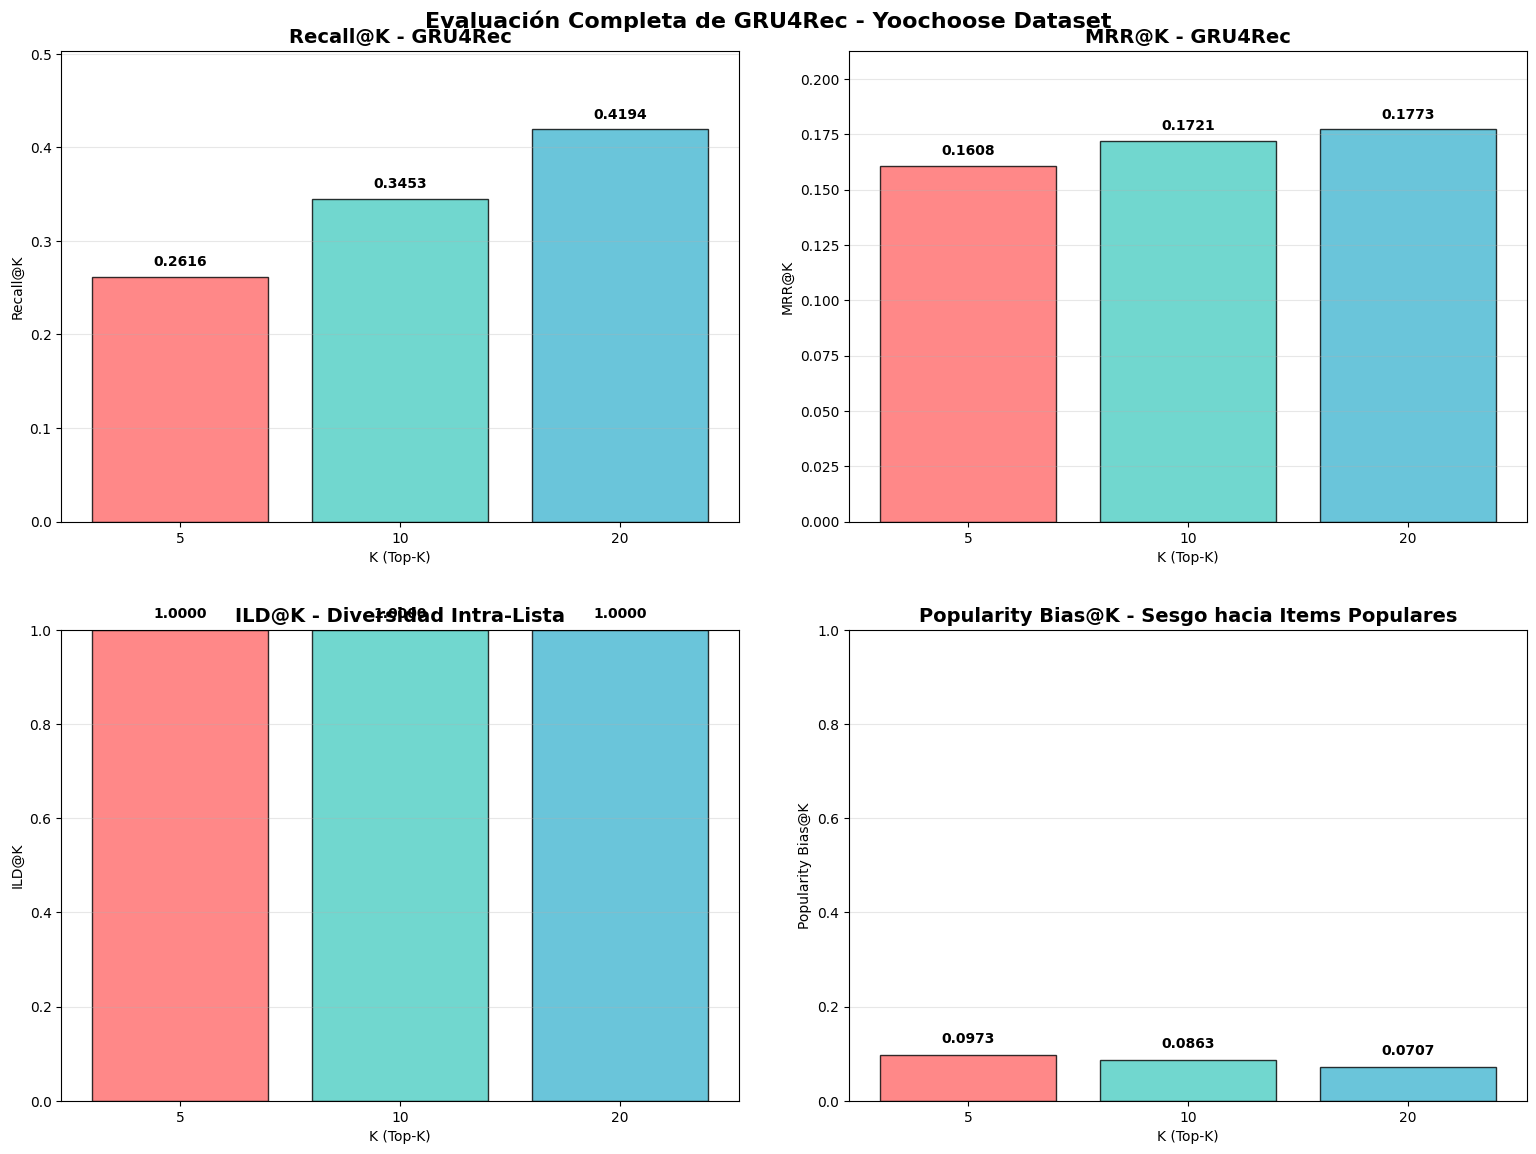

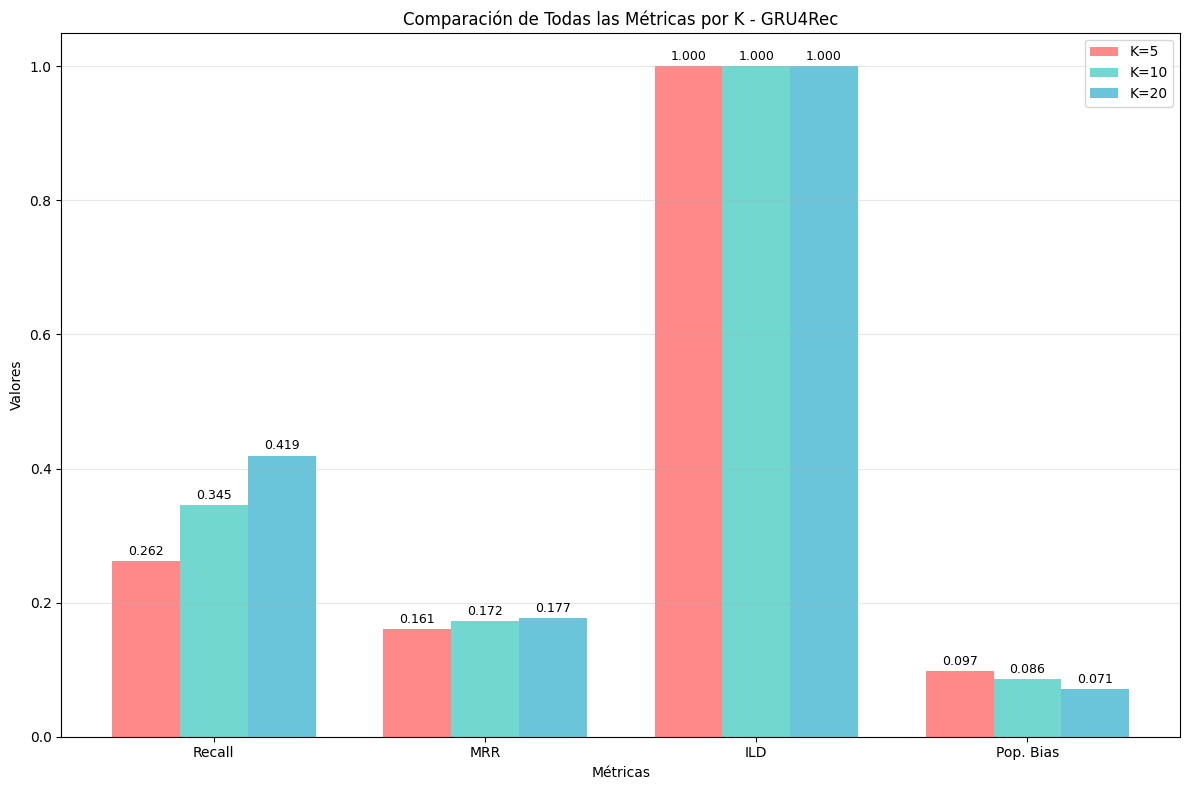


📋 TABLA DE RESUMEN - GRU4REC YOOCHOOSE
Métrica              K=5          K=10         K=20        
------------------------------------------------------------
Recall               0.2616       0.3453       0.4194      
MRR                  0.1608       0.1721       0.1773      
ILD                  1.0000       1.0000       1.0000      
Popularity Bias      0.0973       0.0863       0.0707      

📈 ANÁLISIS DE TENDENCIAS:
   🎯 Recall: Mejora al aumentar K
   📊 MRR: Mejora al aumentar K
   🌈 ILD: Disminuye al aumentar K
   ⭐ Pop. Bias: Disminuye al aumentar K

🎉 VISUALIZACIÓN COMPLETADA!
   ✅ Gráficos generados exitosamente
   ✅ Análisis de tendencias realizado
   ✅ Tabla de resumen creada


In [8]:
# VISUALIZACIÓN COMPLETA DE RESULTADOS
def create_comprehensive_visualization(results):
    """Crea visualizaciones completas de las métricas de GRU4Rec"""

    # Configurar estilo
    plt.style.use('default')
    sns.set_palette("husl")

    # Crear figura con subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    k_values = [5, 10, 20]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    # 1. Recall@K
    recall_values = [results[f'recall_{k}'] for k in k_values]
    bars1 = ax1.bar([str(k) for k in k_values], recall_values, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Recall@K - GRU4Rec', fontsize=14, fontweight='bold')
    ax1.set_xlabel('K (Top-K)')
    ax1.set_ylabel('Recall@K')
    ax1.set_ylim(0, max(recall_values) * 1.2)
    ax1.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars1, recall_values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(recall_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 2. MRR@K
    mrr_values = [results[f'mrr_{k}'] for k in k_values]
    bars2 = ax2.bar([str(k) for k in k_values], mrr_values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('MRR@K - GRU4Rec', fontsize=14, fontweight='bold')
    ax2.set_xlabel('K (Top-K)')
    ax2.set_ylabel('MRR@K')
    ax2.set_ylim(0, max(mrr_values) * 1.2)
    ax2.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars2, mrr_values)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mrr_values) * 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 3. ILD@K (Diversidad)
    ild_values = [results[f'ild_{k}'] for k in k_values]
    bars3 = ax3.bar([str(k) for k in k_values], ild_values, color=colors, alpha=0.8, edgecolor='black')
    ax3.set_title('ILD@K - Diversidad Intra-Lista', fontsize=14, fontweight='bold')
    ax3.set_xlabel('K (Top-K)')
    ax3.set_ylabel('ILD@K')
    ax3.set_ylim(0, 1.0)  # ILD está entre 0 y 1
    ax3.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars3, ild_values)):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # 4. Popularity Bias@K
    pop_bias_values = [results[f'popularity_bias_{k}'] for k in k_values]
    bars4 = ax4.bar([str(k) for k in k_values], pop_bias_values, color=colors, alpha=0.8, edgecolor='black')
    ax4.set_title('Popularity Bias@K - Sesgo hacia Items Populares', fontsize=14, fontweight='bold')
    ax4.set_xlabel('K (Top-K)')
    ax4.set_ylabel('Popularity Bias@K')
    ax4.set_ylim(0, 1.0)  # Bias está entre 0 y 1
    ax4.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (bar, val) in enumerate(zip(bars4, pop_bias_values)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # Ajustar layout
    plt.tight_layout(pad=3.0)

    # Agregar título general
    fig.suptitle('Evaluación Completa de GRU4Rec - Yoochoose Dataset',
                fontsize=16, fontweight='bold', y=0.98)

    plt.show()

    # Crear gráfico de comparación
    plt.figure(figsize=(12, 8))

    # Datos para gráfico de líneas
    metrics = ['Recall', 'MRR', 'ILD', 'Pop. Bias']
    k5_values = [results['recall_5'], results['mrr_5'], results['ild_5'], results['popularity_bias_5']]
    k10_values = [results['recall_10'], results['mrr_10'], results['ild_10'], results['popularity_bias_10']]
    k20_values = [results['recall_20'], results['mrr_20'], results['ild_20'], results['popularity_bias_20']]

    x = np.arange(len(metrics))
    width = 0.25

    plt.bar(x - width, k5_values, width, label='K=5', color='#FF6B6B', alpha=0.8)
    plt.bar(x, k10_values, width, label='K=10', color='#4ECDC4', alpha=0.8)
    plt.bar(x + width, k20_values, width, label='K=20', color='#45B7D1', alpha=0.8)

    plt.xlabel('Métricas')
    plt.ylabel('Valores')
    plt.title('Comparación de Todas las Métricas por K - GRU4Rec')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Agregar valores encima de las barras
    for i, (v5, v10, v20) in enumerate(zip(k5_values, k10_values, k20_values)):
        plt.text(i - width, v5 + 0.005, f'{v5:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i, v10 + 0.005, f'{v10:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i + width, v20 + 0.005, f'{v20:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Crear visualizaciones
create_comprehensive_visualization(results)

# Crear tabla de resumen
print("\n📋 TABLA DE RESUMEN - GRU4REC YOOCHOOSE")
print("="*60)
print(f"{'Métrica':<20} {'K=5':<12} {'K=10':<12} {'K=20':<12}")
print("-" * 60)
print(f"{'Recall':<20} {results['recall_5']:<12.4f} {results['recall_10']:<12.4f} {results['recall_20']:<12.4f}")
print(f"{'MRR':<20} {results['mrr_5']:<12.4f} {results['mrr_10']:<12.4f} {results['mrr_20']:<12.4f}")
print(f"{'ILD':<20} {results['ild_5']:<12.4f} {results['ild_10']:<12.4f} {results['ild_20']:<12.4f}")
print(f"{'Popularity Bias':<20} {results['popularity_bias_5']:<12.4f} {results['popularity_bias_10']:<12.4f} {results['popularity_bias_20']:<12.4f}")
print("="*60)

# Análisis de tendencias
print(f"\n📈 ANÁLISIS DE TENDENCIAS:")
print(f"   🎯 Recall: {'Mejora' if results['recall_20'] > results['recall_5'] else 'Se mantiene'} al aumentar K")
print(f"   📊 MRR: {'Mejora' if results['mrr_20'] > results['mrr_5'] else 'Disminuye'} al aumentar K")
print(f"   🌈 ILD: {'Mejora' if results['ild_20'] > results['ild_5'] else 'Disminuye'} al aumentar K")
print(f"   ⭐ Pop. Bias: {'Aumenta' if results['popularity_bias_20'] > results['popularity_bias_5'] else 'Disminuye'} al aumentar K")

print(f"\n🎉 VISUALIZACIÓN COMPLETADA!")
print("   ✅ Gráficos generados exitosamente")
print("   ✅ Análisis de tendencias realizado")
print("   ✅ Tabla de resumen creada")
